# Imports

In [156]:
#manipulação de dados
import pandas as pd
import numpy  as np

#visualização
import matplotlib.pyplot as plt
import seaborn           as sns
from IPython.core.display import HTML
import umap.umap_ as umap

#metricas
import sklearn.metrics
import scikitplot                         as skplt
from scipy                 import stats
from sklearn               import manifold as mn
from yellowbrick.cluster   import KElbowVisualizer, SilhouetteVisualizer

# processamento de dados
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import pickle

#modelos
from sklearn.ensemble     import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn              import mixture      as mx
from scipy.cluster        import hierarchy     as hr
from sklearn.neighbors    import NearestNeighbors
from sklearn              import decomposition as  dcp
from sklearn              import cluster       as c

## Helper functions

In [119]:
# configuração do jupyter notebook e plotagem de imagens
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    sns.set()
jupyter_settings()

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [120]:
import warnings
warnings.filterwarnings("ignore")

In [121]:
def precision_at_k( data, k=200 ):
    """
    Object that return the precision at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the precision at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['precision_at_k'] = data['response'].cumsum() / data['ranking']

    return data.loc[k, 'precision_at_k']


def recall_at_k( data, k=200 ):
    """
    Object that return the recall at k  of recommended items in the top-k set that are relevant
    :param data: dataframe that will be calculated the recall at k position
    :param k: int, default=2000, position that the metric will be calculated default='2000'
    :return: a float value
    """
    # reset index
    data = data.reset_index( drop=True )

    # create ranking order
    data['ranking'] = data.index + 1

    data['recall_at_k'] = data['response'].cumsum() / data['response'].sum()

    return data.loc[k, 'recall_at_k']


def performace(model_name, data, y_val, yhat_class, k=200):
    """

    :param model_name: string, with the name of the algoritm that will be used
    :param data: dataframe sorted by  probabilit given to each iten by the model
    :param y_val: list of the target variable of the dataframe
    :param yhat_class: binary prediction made by the model for each iten
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.metrics
    prec = sklearn.metrics.precision_score(y_val, yhat_class,average='macro')
    recal = sklearn.metrics.recall_score(y_val, yhat_class,average='macro')
    balanced_acc = sklearn.metrics.balanced_accuracy_score(y_val, yhat_class)
    recal_k = recall_at_k(data, k)
    prec_k = precision_at_k(data, k)

    return pd.DataFrame({'Model Name': model_name,
                         'Precison': prec,
                         'Recall': recal,
                         'Balanced_acc': balanced_acc,
                         'k': k,
                         'Precison at k': prec_k,
                         'Recall at k': recal_k}, index=[0])



In [122]:
def performace_cross_val(data, target, model, model_name, round_n=4, splits=3, shuffle_n=True, random=42, k=200):
    """
    this cross-validation object uses kfold with stratified folds and return the metrics
    :param data: dataframe
    :param target: string, name of the target variable
    :param model: model that will be used
    :param model_name: string with the model name
    :param round_n: int, default=5number of decimal points of the float values that will be returned
    :param splits: int, default=5, number of folds
    :param shuffle_n:bool, default=True, Whether to shuffle each class’s samples before splitting into batches
    :param random: int, default=42 controls the randomness of each fold
    :param k: int, default=2000 position that the metric will be calculated default='2000'
    :return: a dataframe with the mean and standard deviation of the metrics: [precision,recall, balanced accuracy, precision at k, recall at k]
    """
    import sklearn.model_selection as ms
    import sklearn.metrics
    import numpy as np
    skf = ms.StratifiedKFold(n_splits=splits, shuffle=shuffle_n, random_state=random)
    X = data
    y = X[target]
    X = X.drop(columns=[target, 'id'])
    precision = []
    recall = []
    balan_acc = []
    prec_k = []
    rec_k = []
    for train_index, test_index in skf.split(X, y):
        # train the model
        model.fit(X.iloc[train_index], y.iloc[train_index].values.ravel())

        # predict the classification
        yhat_class = model.predict(X.iloc[test_index])

        # predict the probabilit
        yhat_proba = model.predict_proba(X.iloc[test_index])

        # precision and recall
        prec = sklearn.metrics.precision_score(y.iloc[test_index], yhat_class,average='macro')
        rec = sklearn.metrics.recall_score(y.iloc[test_index], yhat_class,average='macro')
        balan_acc_score = sklearn.metrics.balanced_accuracy_score(y.iloc[test_index], yhat_class)
        precision.append(prec)
        recall.append(rec)
        balan_acc.append(balan_acc_score)

        # sort the test dataframe by the probabiliti score of the model
        aux = X.iloc[test_index]
        aux[target] = y.iloc[test_index]
        aux['score'] = yhat_proba[:, 1].tolist()

        # sorte by score
        aux = aux.sort_values('score', ascending=False)

        # precision and recall at k
        prec_k.append(precision_at_k(aux, k))
        rec_k.append(recall_at_k(aux, k))

    # return a dataset with the metrics
    return pd.DataFrame({'model name': model_name + " CV",
                        'precision_cv': np.round(np.mean(precision), round_n),
                        'prec_std': np.round(np.std(precision), round_n),
                        'recall_cv': np.round(np.mean(recall), round_n),
                        'rec_std': np.round(np.std(recall), round_n),
                        'balanced_acc_cv': np.round(np.mean(balan_acc), round_n),
                        'bal_std': np.round(np.std(balan_acc), round_n),
                        'k': k,
                        'precision_at_k_cv': np.round(np.mean(prec_k), round_n),
                        'perc_k_std': np.round(np.std(prec_k), round_n),
                        'recall_at_k_cv': np.round(np.mean(rec_k), round_n),
                        'rec_k_std': np.round(np.std(rec_k))}, index=[0])




# Load data 

In [123]:
path_local = 'C:/Users/Lavin/Documents/desafios/ifood/'

In [124]:
df7 = pd.read_csv(path_local + 'data/processed/df5.csv')

In [125]:
df7.head()

,id,marital_status,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,...,accepted_cmp3,accepted_cmp5,accepted_cmp1,age,n_family_members,days_since_signup,income_per_member,total_spent,total_accepted,response
0,5524,0.22,0.351086,0.585859,0.425318,0.442211,0.554878,0.664093,0.335878,0.274143,...,0,0,0,0.696429,1,0.948498,0.373613,0.639683,0,1
1,2174,0.22,0.277680,0.383838,0.007368,0.005025,0.006098,0.007722,0.003817,0.018692,...,0,0,0,0.750000,3,0.161660,0.094444,0.008730,0,0
2,4141,0.25,0.434956,0.262626,0.285332,0.246231,0.129065,0.428571,0.080153,0.130841,...,0,0,0,0.553571,2,0.446352,0.227577,0.305952,0,0
3,6182,0.25,0.155079,0.262626,0.007368,0.020101,0.020325,0.038610,0.011450,0.015576,...,0,0,0,0.214286,3,0.198856,0.051506,0.019048,0,0
4,5324,0.39,0.352051,0.949495,0.115874,0.216080,0.119919,0.177606,0.103053,0.046729,...,0,0,0,0.267857,3,0.230329,0.120491,0.165476,0,0


# Select columns 

**Para a segmentação de clientes algumas variaveis serão deixadas de lado nesse momento**

In [126]:
df_ref = df7[['id','response']]

In [127]:
cols_selected = ['id','income', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'age','n_family_members', 'days_since_signup', 'income_per_member',
       'total_spent']
df8 = df7[cols_selected]

# Fine tuning 

In [128]:
X = df8.drop(columns='id')

In [129]:
X.head()

,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,age,n_family_members,days_since_signup,income_per_member,total_spent
0,0.351086,0.585859,0.425318,0.442211,0.554878,0.664093,0.335878,0.274143,0.200000,0.296296,0.909091,0.307692,0.35,0.696429,1,0.948498,0.373613,0.639683
1,0.277680,0.383838,0.007368,0.005025,0.006098,0.007722,0.003817,0.018692,0.133333,0.037037,0.090909,0.153846,0.25,0.750000,3,0.161660,0.094444,0.008730
2,0.434956,0.262626,0.285332,0.246231,0.129065,0.428571,0.080153,0.130841,0.066667,0.296296,0.181818,0.769231,0.20,0.553571,2,0.446352,0.227577,0.305952
3,0.155079,0.262626,0.007368,0.020101,0.020325,0.038610,0.011450,0.015576,0.133333,0.074074,0.000000,0.307692,0.30,0.214286,3,0.198856,0.051506,0.019048
4,0.352051,0.949495,0.115874,0.216080,0.119919,0.177606,0.103053,0.046729,0.333333,0.185185,0.272727,0.461538,0.25,0.267857,3,0.230329,0.120491,0.165476


In [130]:
clusters = [2,3,4,5,6,7]

## k-means

In [131]:
sil_k = []
for k in clusters:
    # model definition
    k_model = c.KMeans(n_clusters=k)

    #model training
    k_model.fit(X)

    #model predict
    labels = k_model.predict(X)

    #model performace
    sil_k.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Within-Cluster Sum of Square (WSS)**

In [132]:
wss = []
for k in clusters:
    # model definition
    kmeans = c.KMeans(init='random', n_clusters=k, n_init=10,max_iter=300,random_state=42)
    #model training
    kmeans.fit(X)
    
    wss.append(kmeans.inertia_)

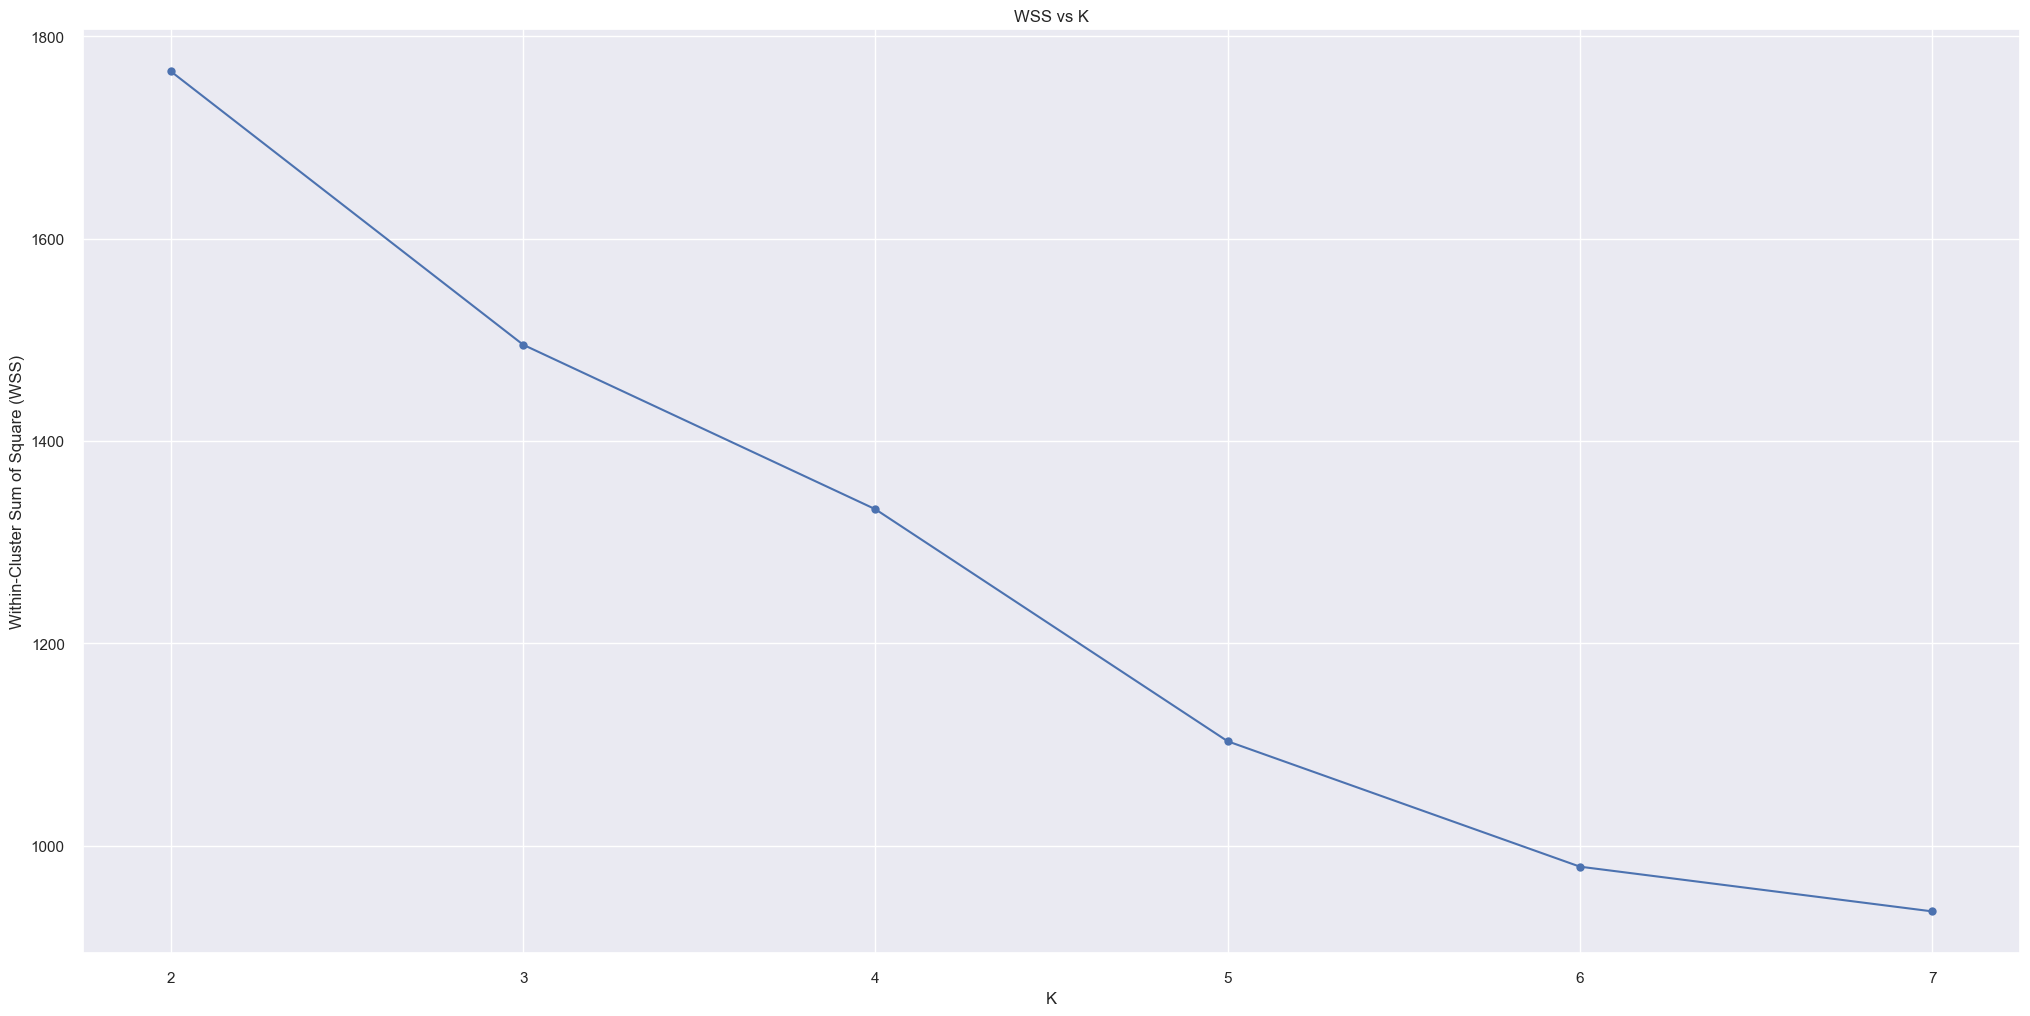

In [133]:
plt.plot(clusters,wss, marker = 'o');
plt.xlabel('K');
plt.ylabel('Within-Cluster Sum of Square (WSS)');
plt.title('WSS vs K');

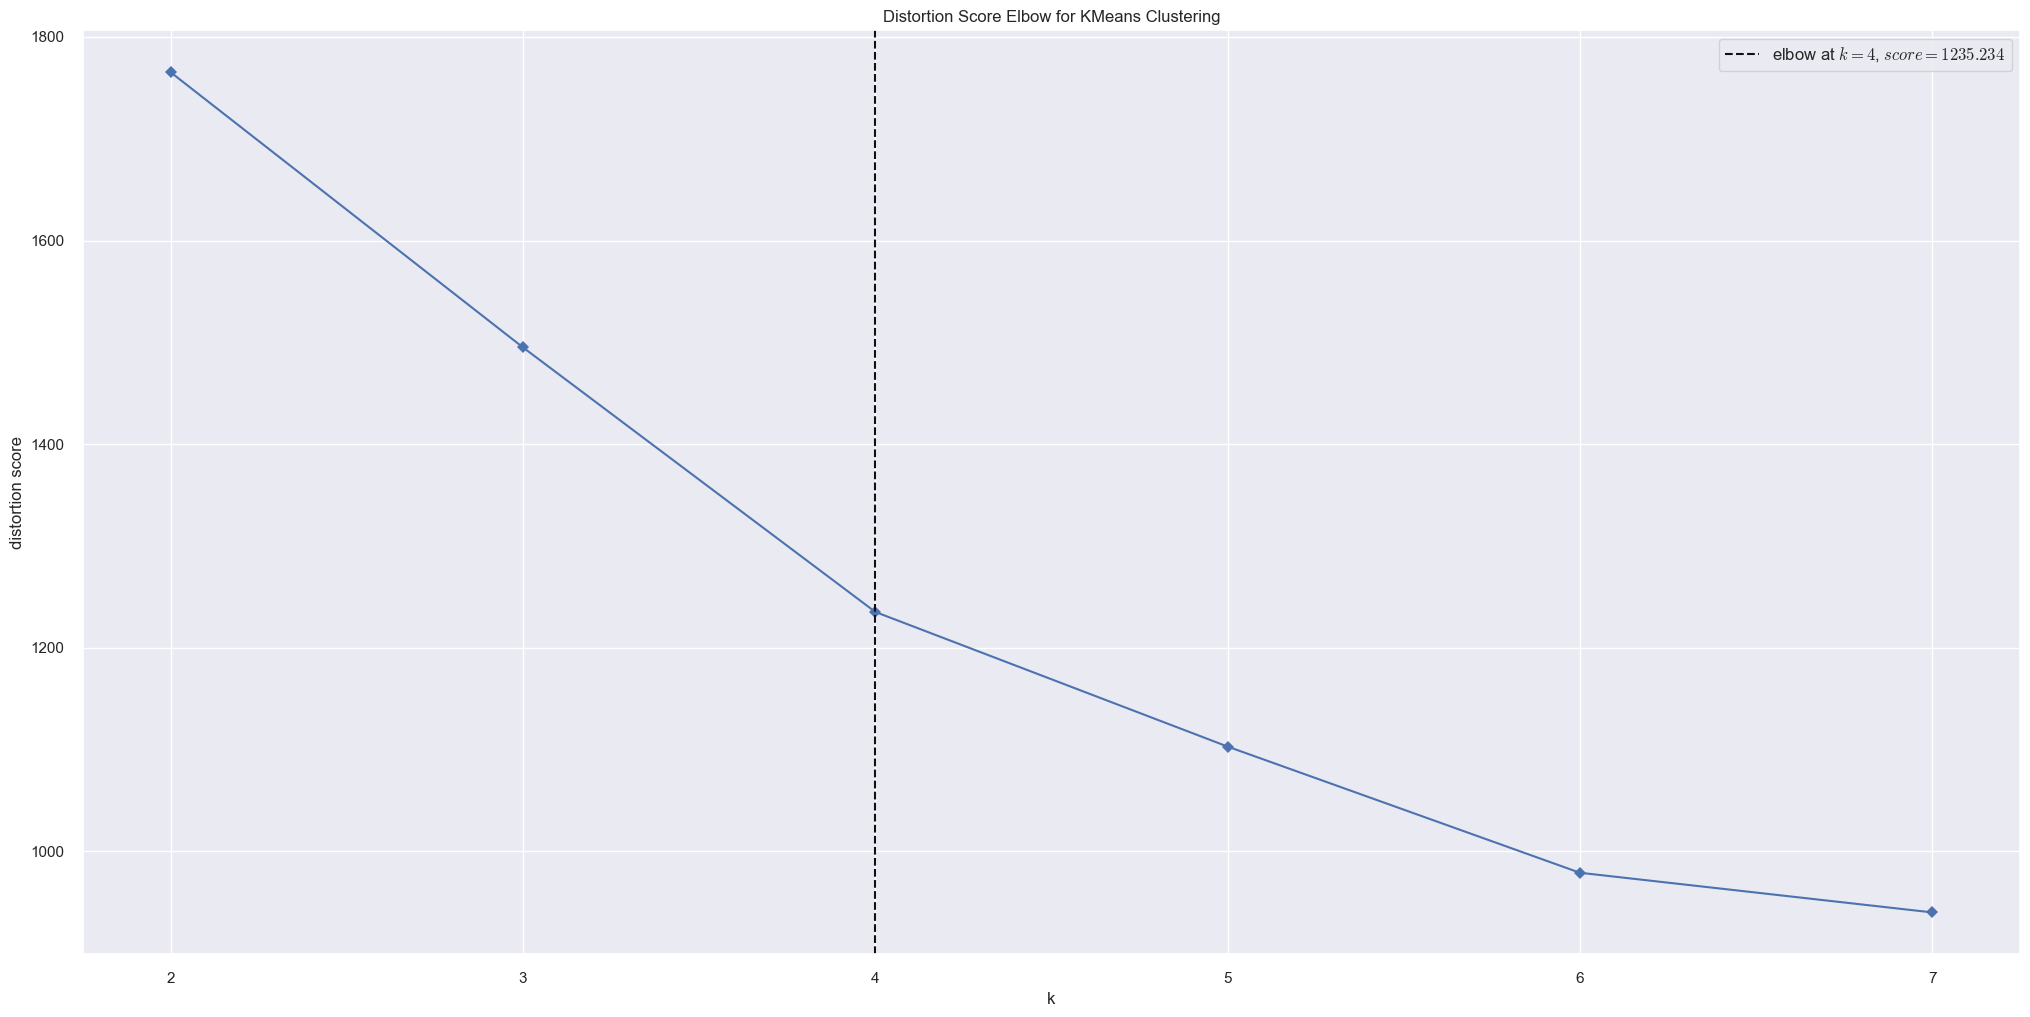

In [134]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,timings=False)
kmeans.fit(X)
kmeans.show();

**Sillhouete Score**

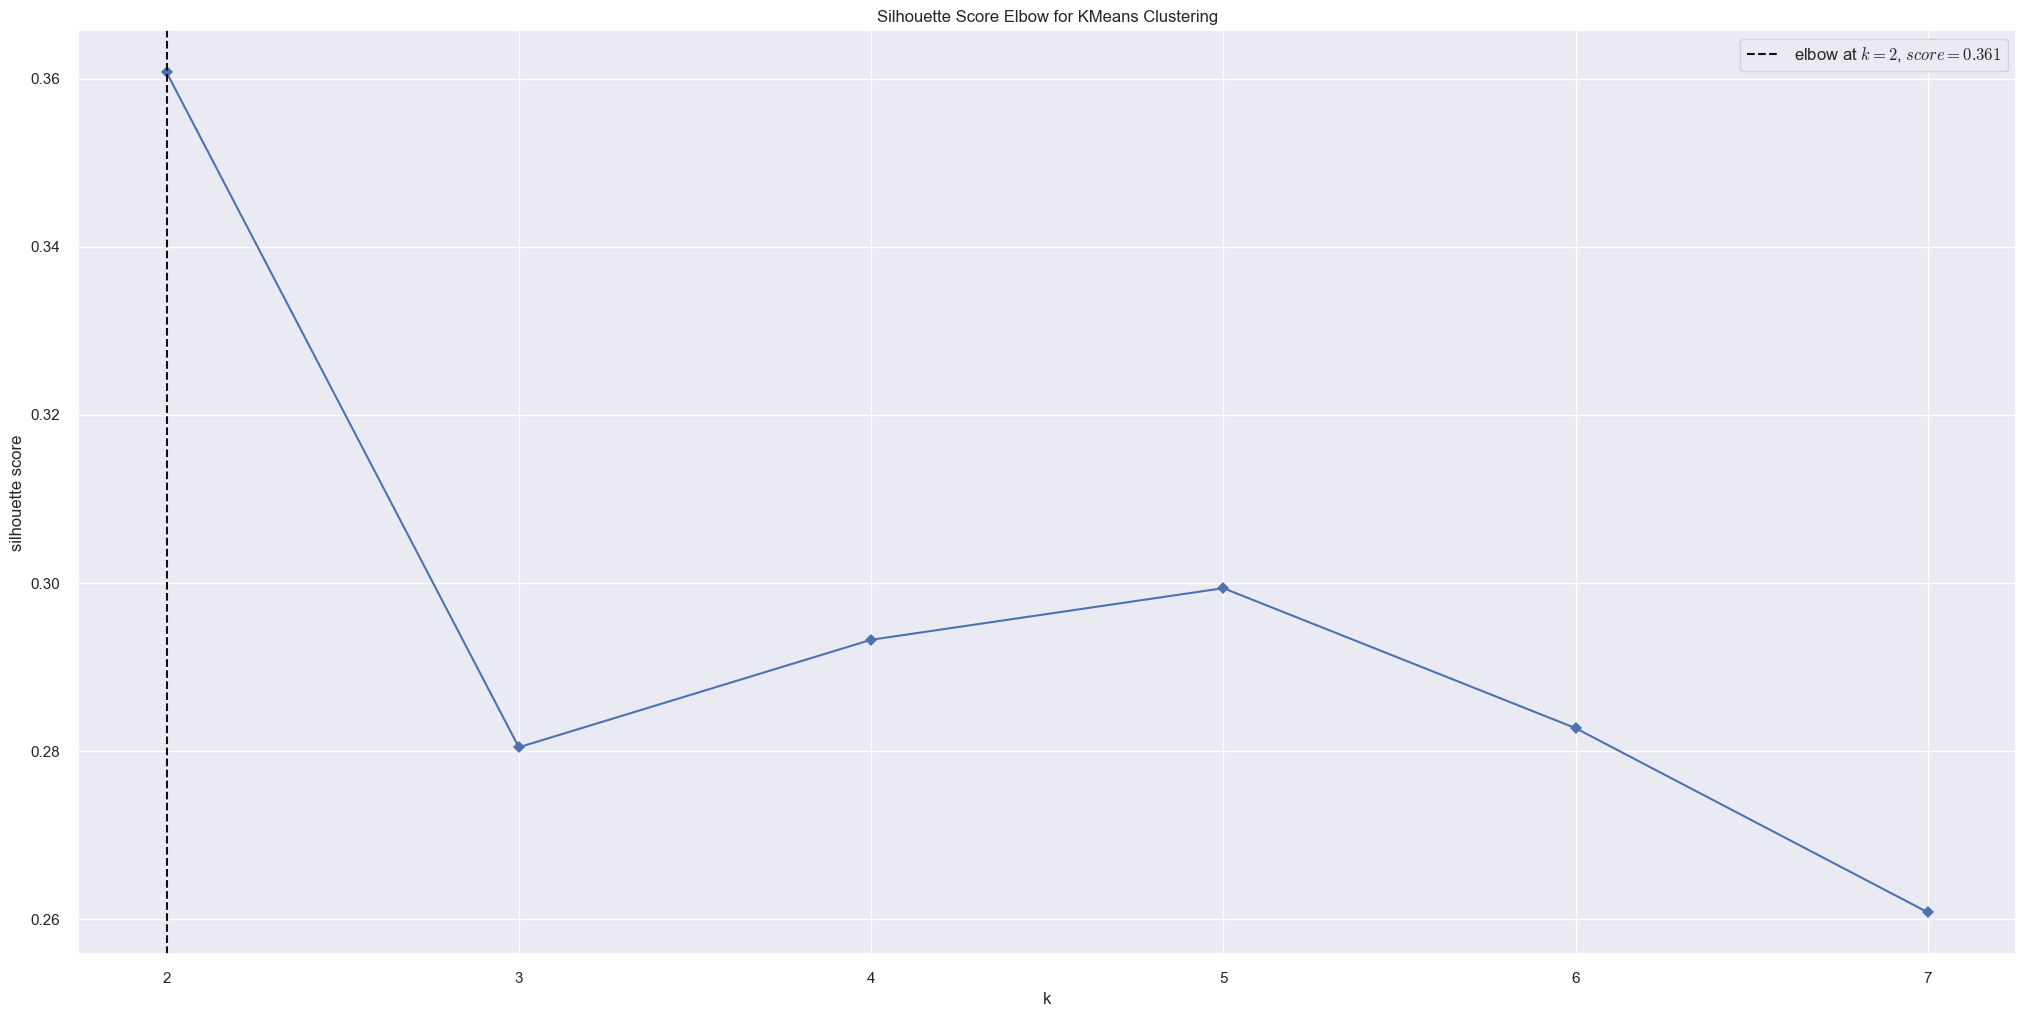

In [135]:
kmeans = KElbowVisualizer(c.KMeans(),k=clusters,metric='silhouette',timings=False)
kmeans.fit(X)
kmeans.show();

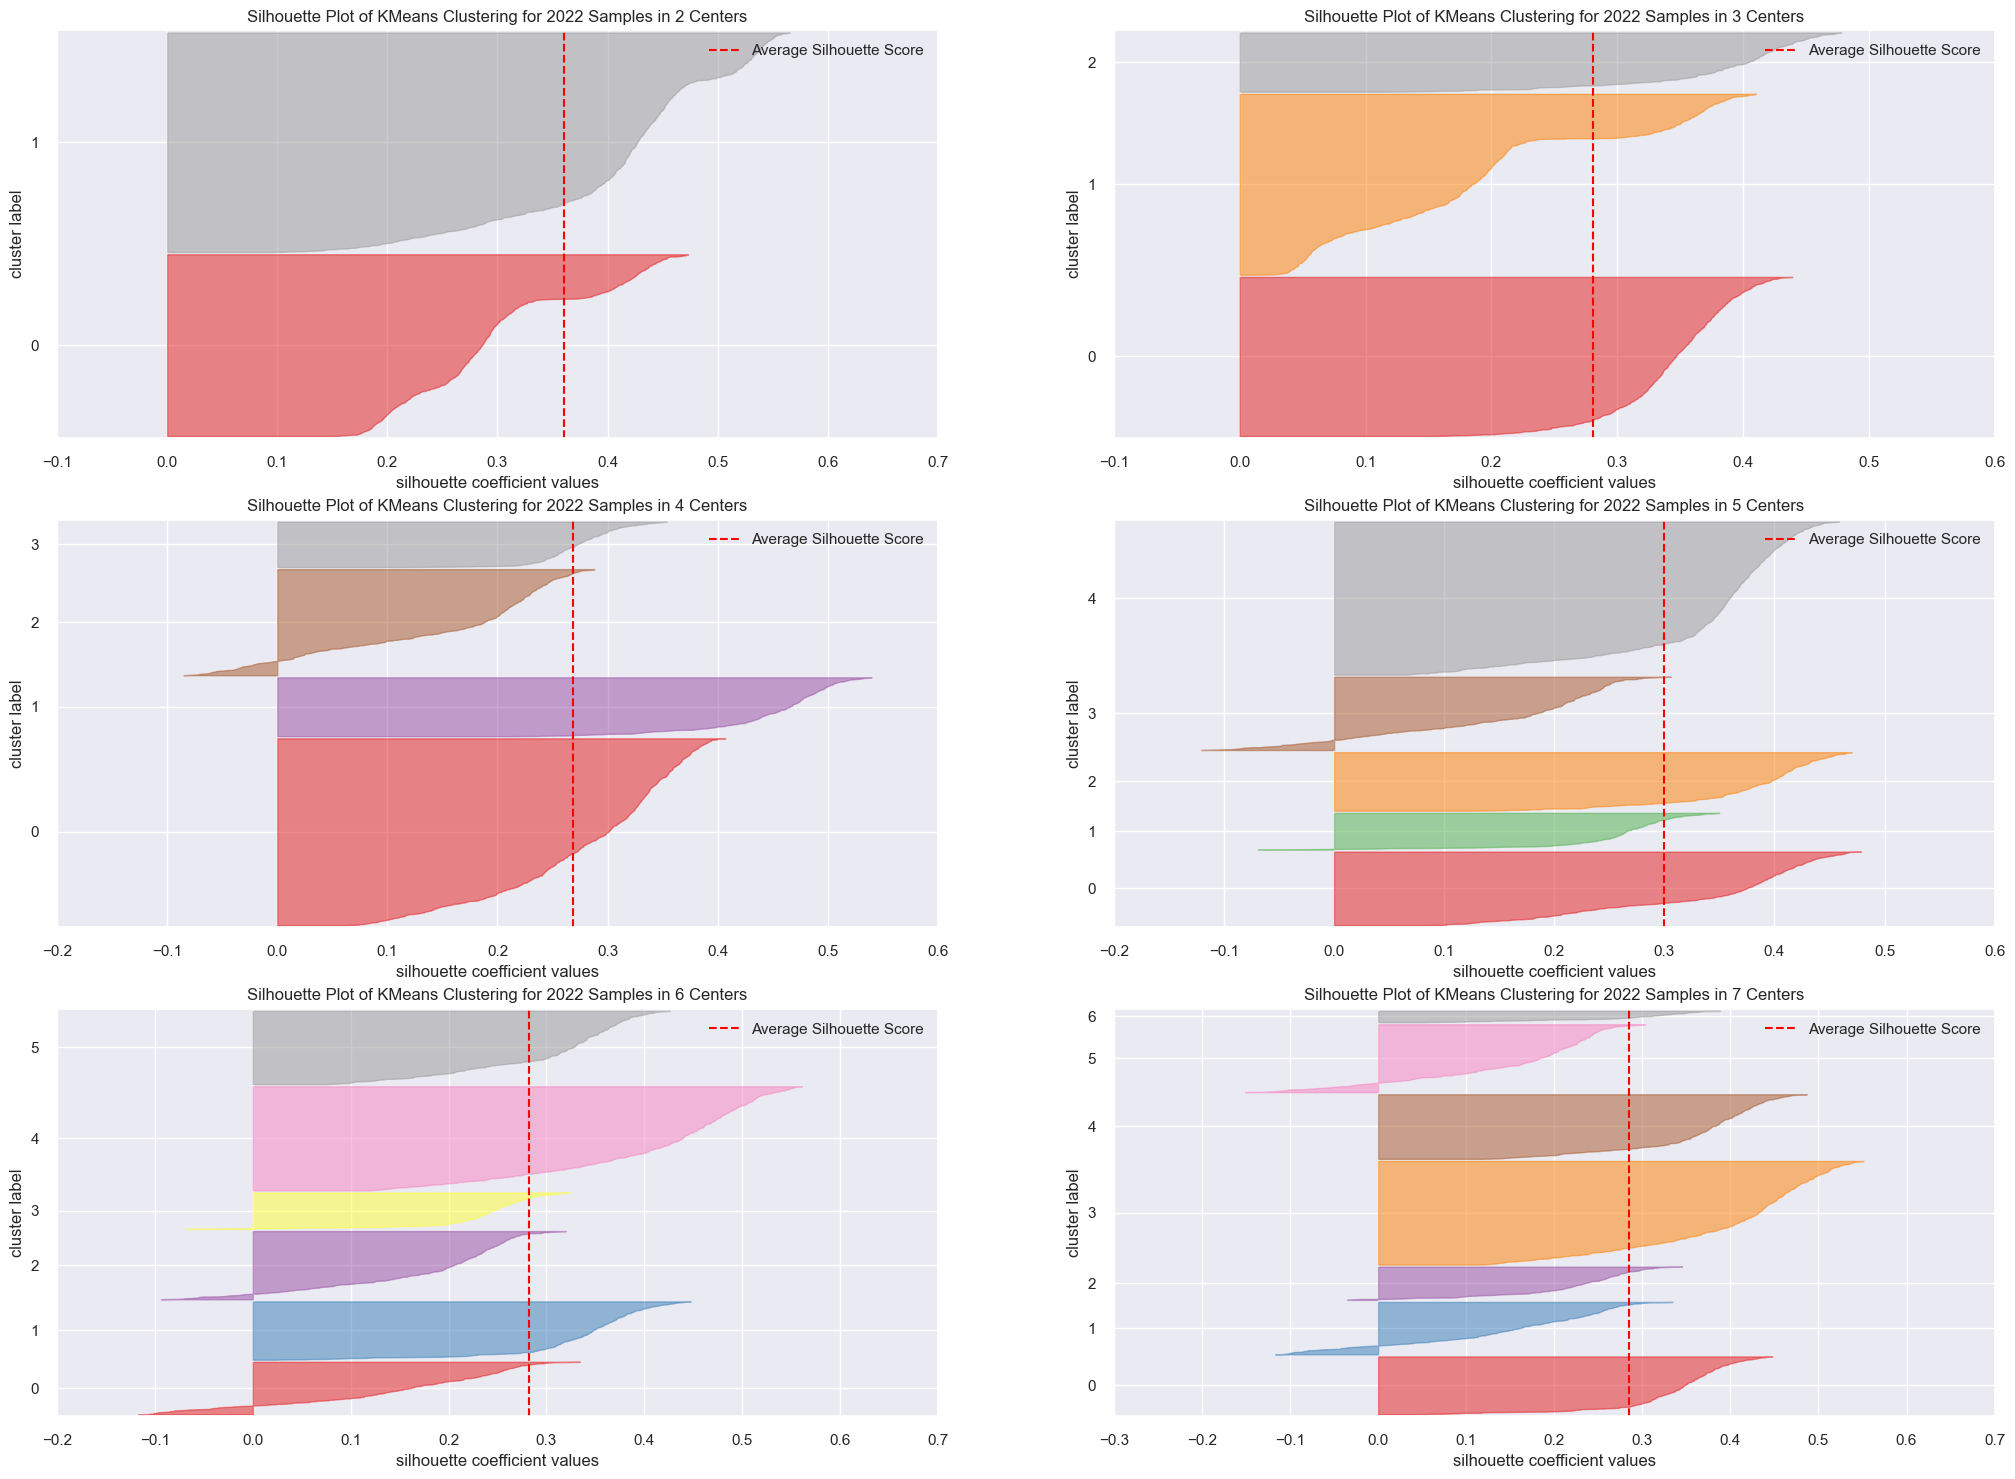

In [136]:
fig, ax = plt.subplots(3,2,figsize=(25,18))
#k=2
for k in clusters:
    km = c.KMeans(n_clusters=k,init='random',n_init=10, max_iter=100,random_state=42)
    l,i = divmod(k,2)
    visualizer = SilhouetteVisualizer(km, color='yellowbrick',ax=ax[l-1][i])
    visualizer.fit(X)
    visualizer.finalize()

## GMM

AIC - ajuste do modelo
BIC - ajuste dos parametros

In [137]:
gmm_list = []
for k in clusters:
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_list.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Sillhouete Score**

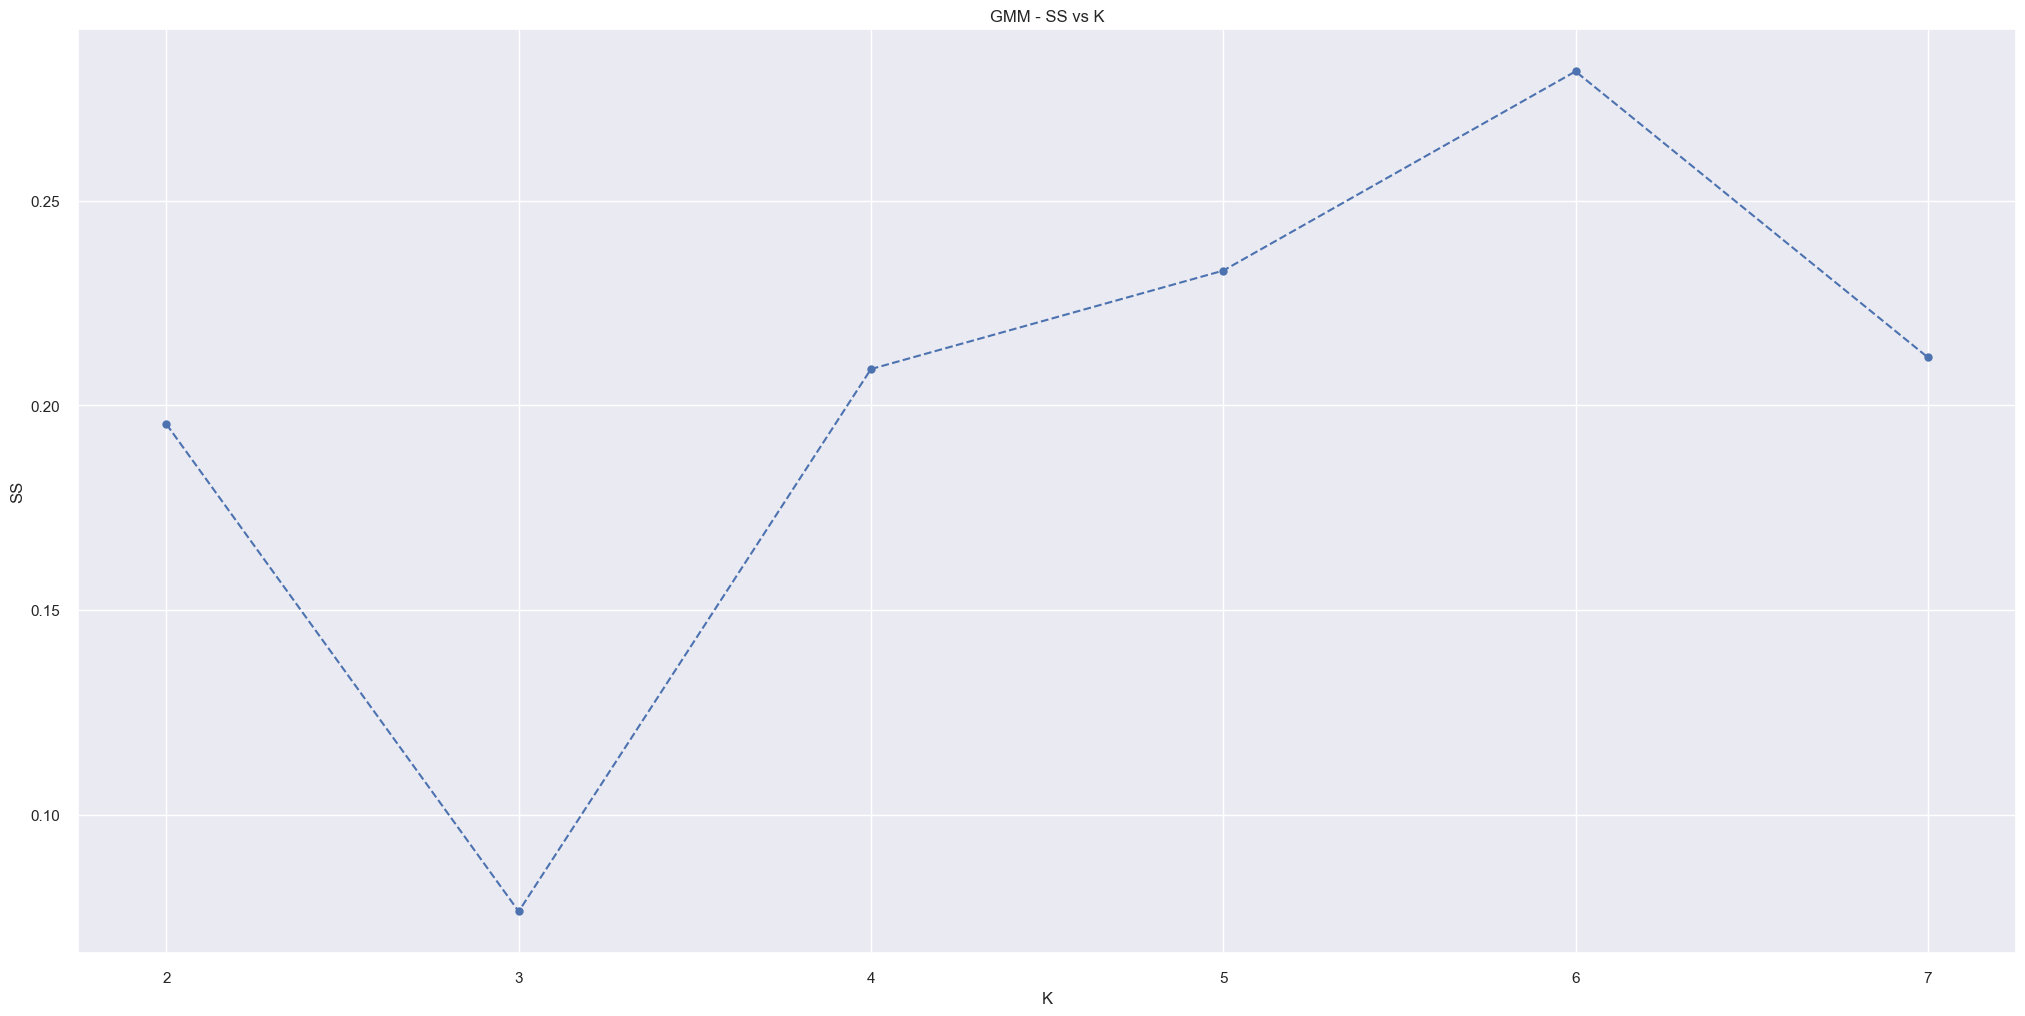

In [138]:
plt.plot(clusters,gmm_list,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('GMM - SS vs K');

**Silhouete analisys**

For K = 2 Silhouette: 0.19538233680603745
For K = 3 Silhouette: 0.29543161992443284
For K = 4 Silhouette: 0.2837704290235608
For K = 5 Silhouette: 0.23291591504488557
For K = 6 Silhouette: 0.16583905794319442
For K = 7 Silhouette: 0.24829612529002998


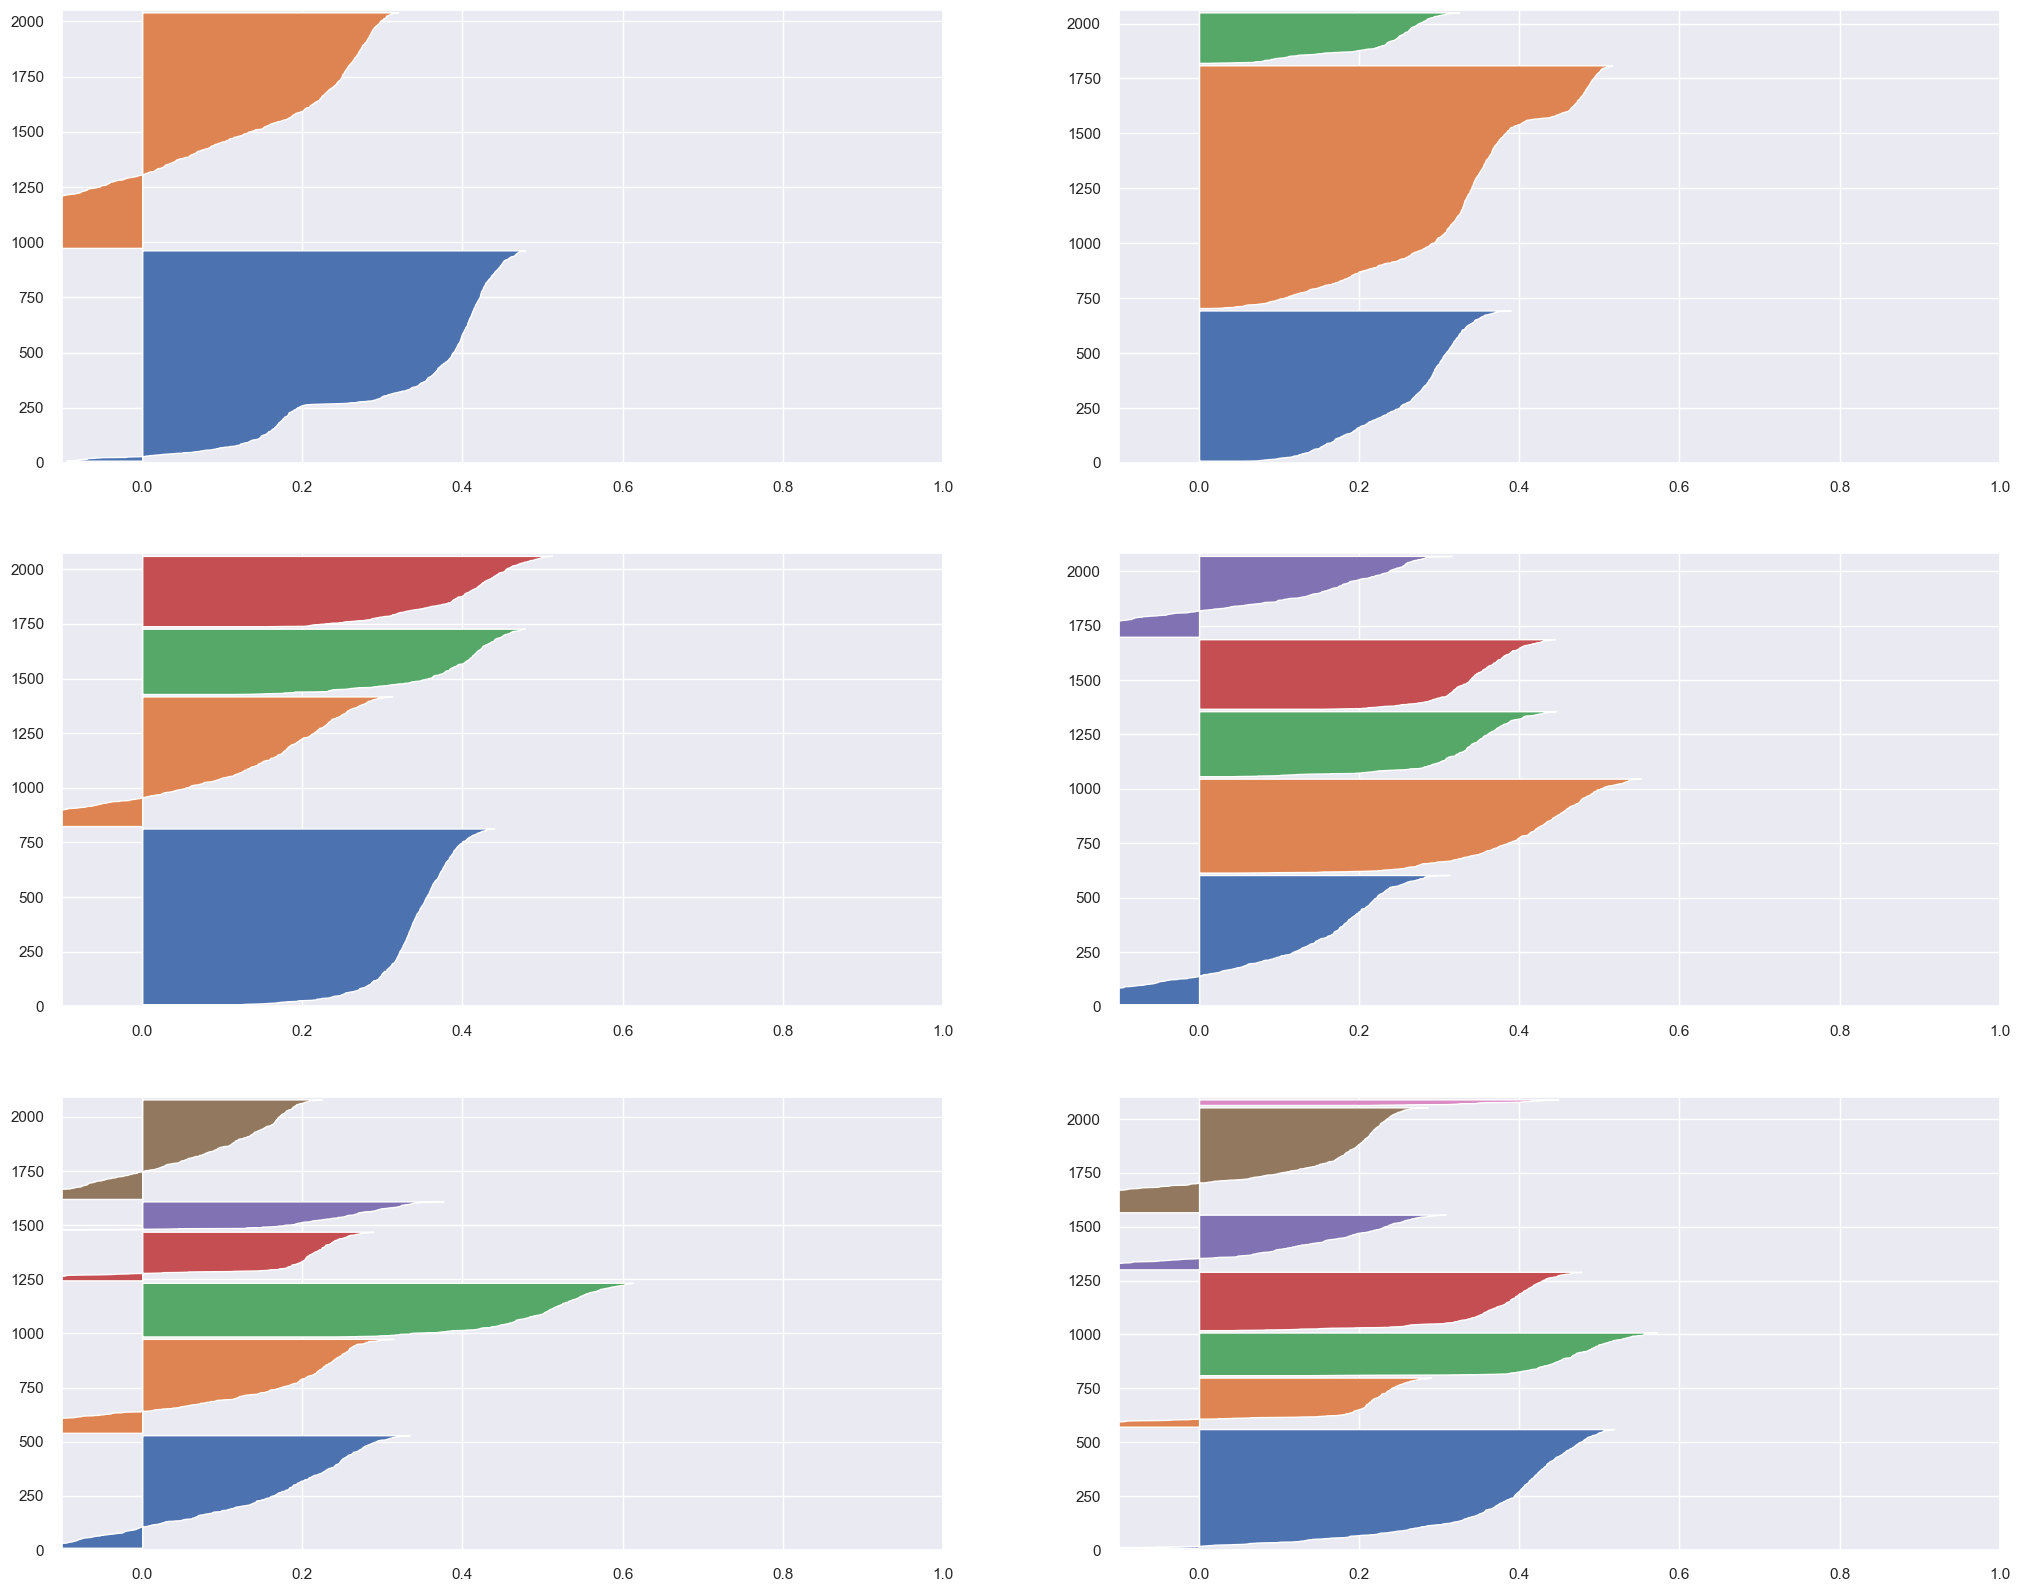

In [139]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition
    gmm_model = mx.GaussianMixture(n_components=k)

    #model training
    gmm_model.fit(X)

    #model predict
    labels = gmm_model.predict(X)

    #model performace
    gmm_k = sklearn.metrics.silhouette_score(X,labels,metric='euclidean')
    print(f'For K = {k} Silhouette: {gmm_k}')
    
    ss_values = sklearn.metrics.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

## H-Clustering

In [140]:
hc_model = hr.linkage(X,'ward')

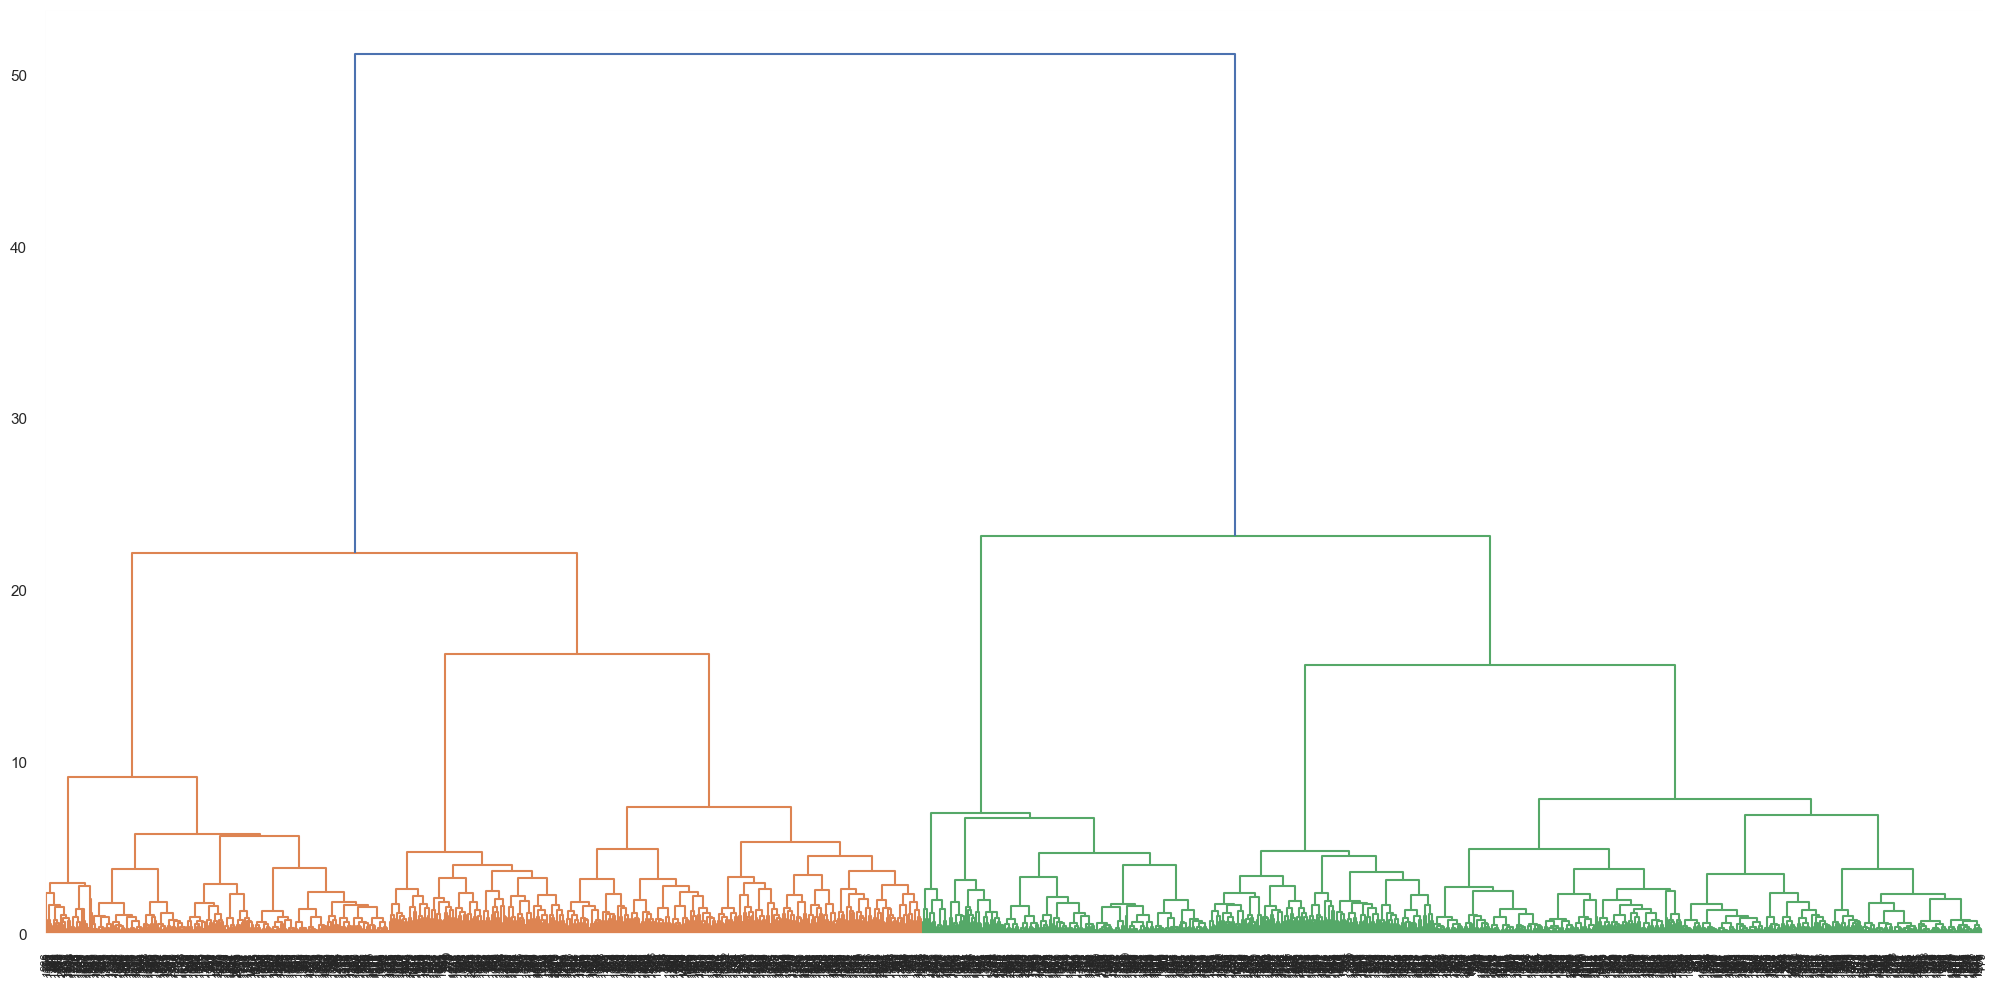

In [141]:
hr.dendrogram(hc_model,
             leaf_rotation=90,
             leaf_font_size=8)
plt.plot();

In [142]:
hc_list = []
for k in clusters:
    # model definition
    hc_model = hr.linkage(X,'ward')

    #model predict
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace
    hc_list.append(sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

**Sillhouete Score**

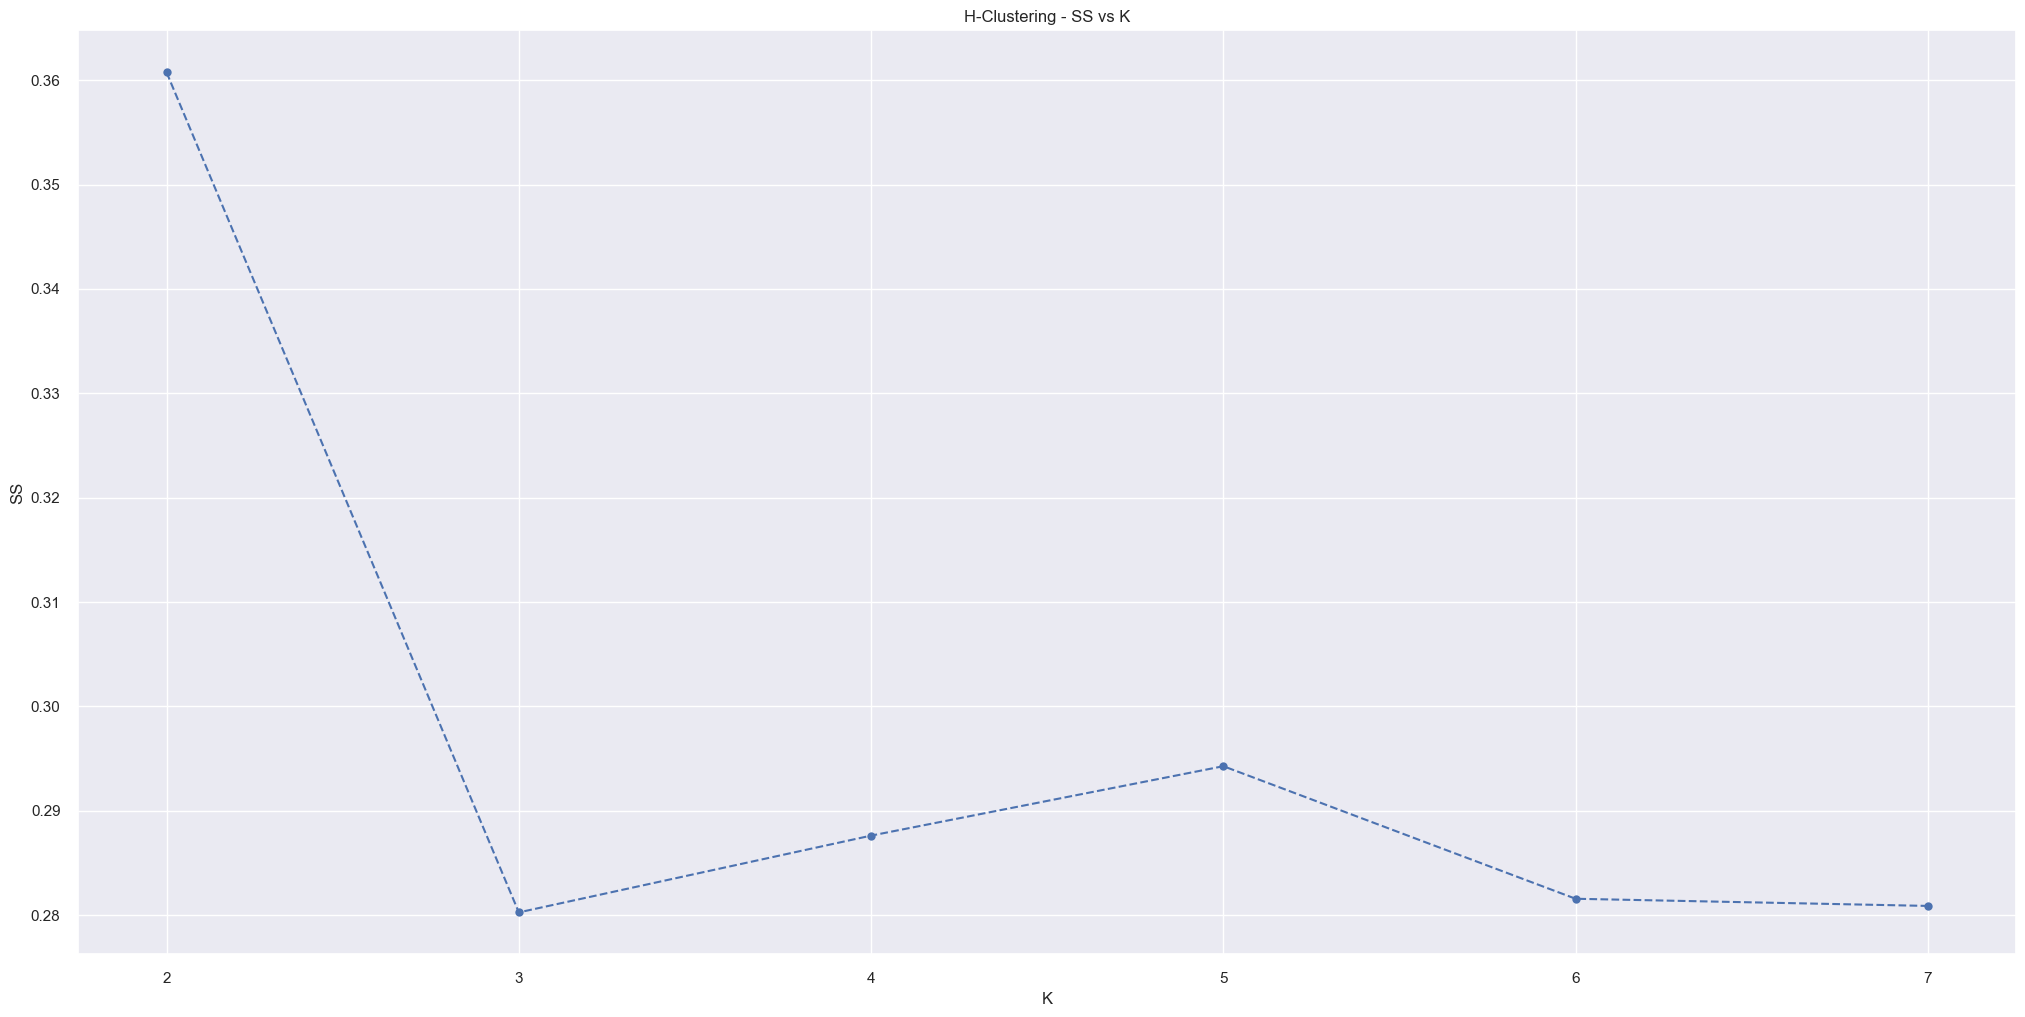

In [143]:
plt.plot(clusters,hc_list,linestyle='--',marker = 'o');
plt.xlabel('K');
plt.ylabel('SS');
plt.title('H-Clustering - SS vs K');

**Silhouete analisys**

For K = 2 Silhouette: 0.36074909551991646
For K = 3 Silhouette: 0.28026367174086625
For K = 4 Silhouette: 0.2876198944240132
For K = 5 Silhouette: 0.294270640987182
For K = 6 Silhouette: 0.28156924868720135
For K = 7 Silhouette: 0.2808832758788526


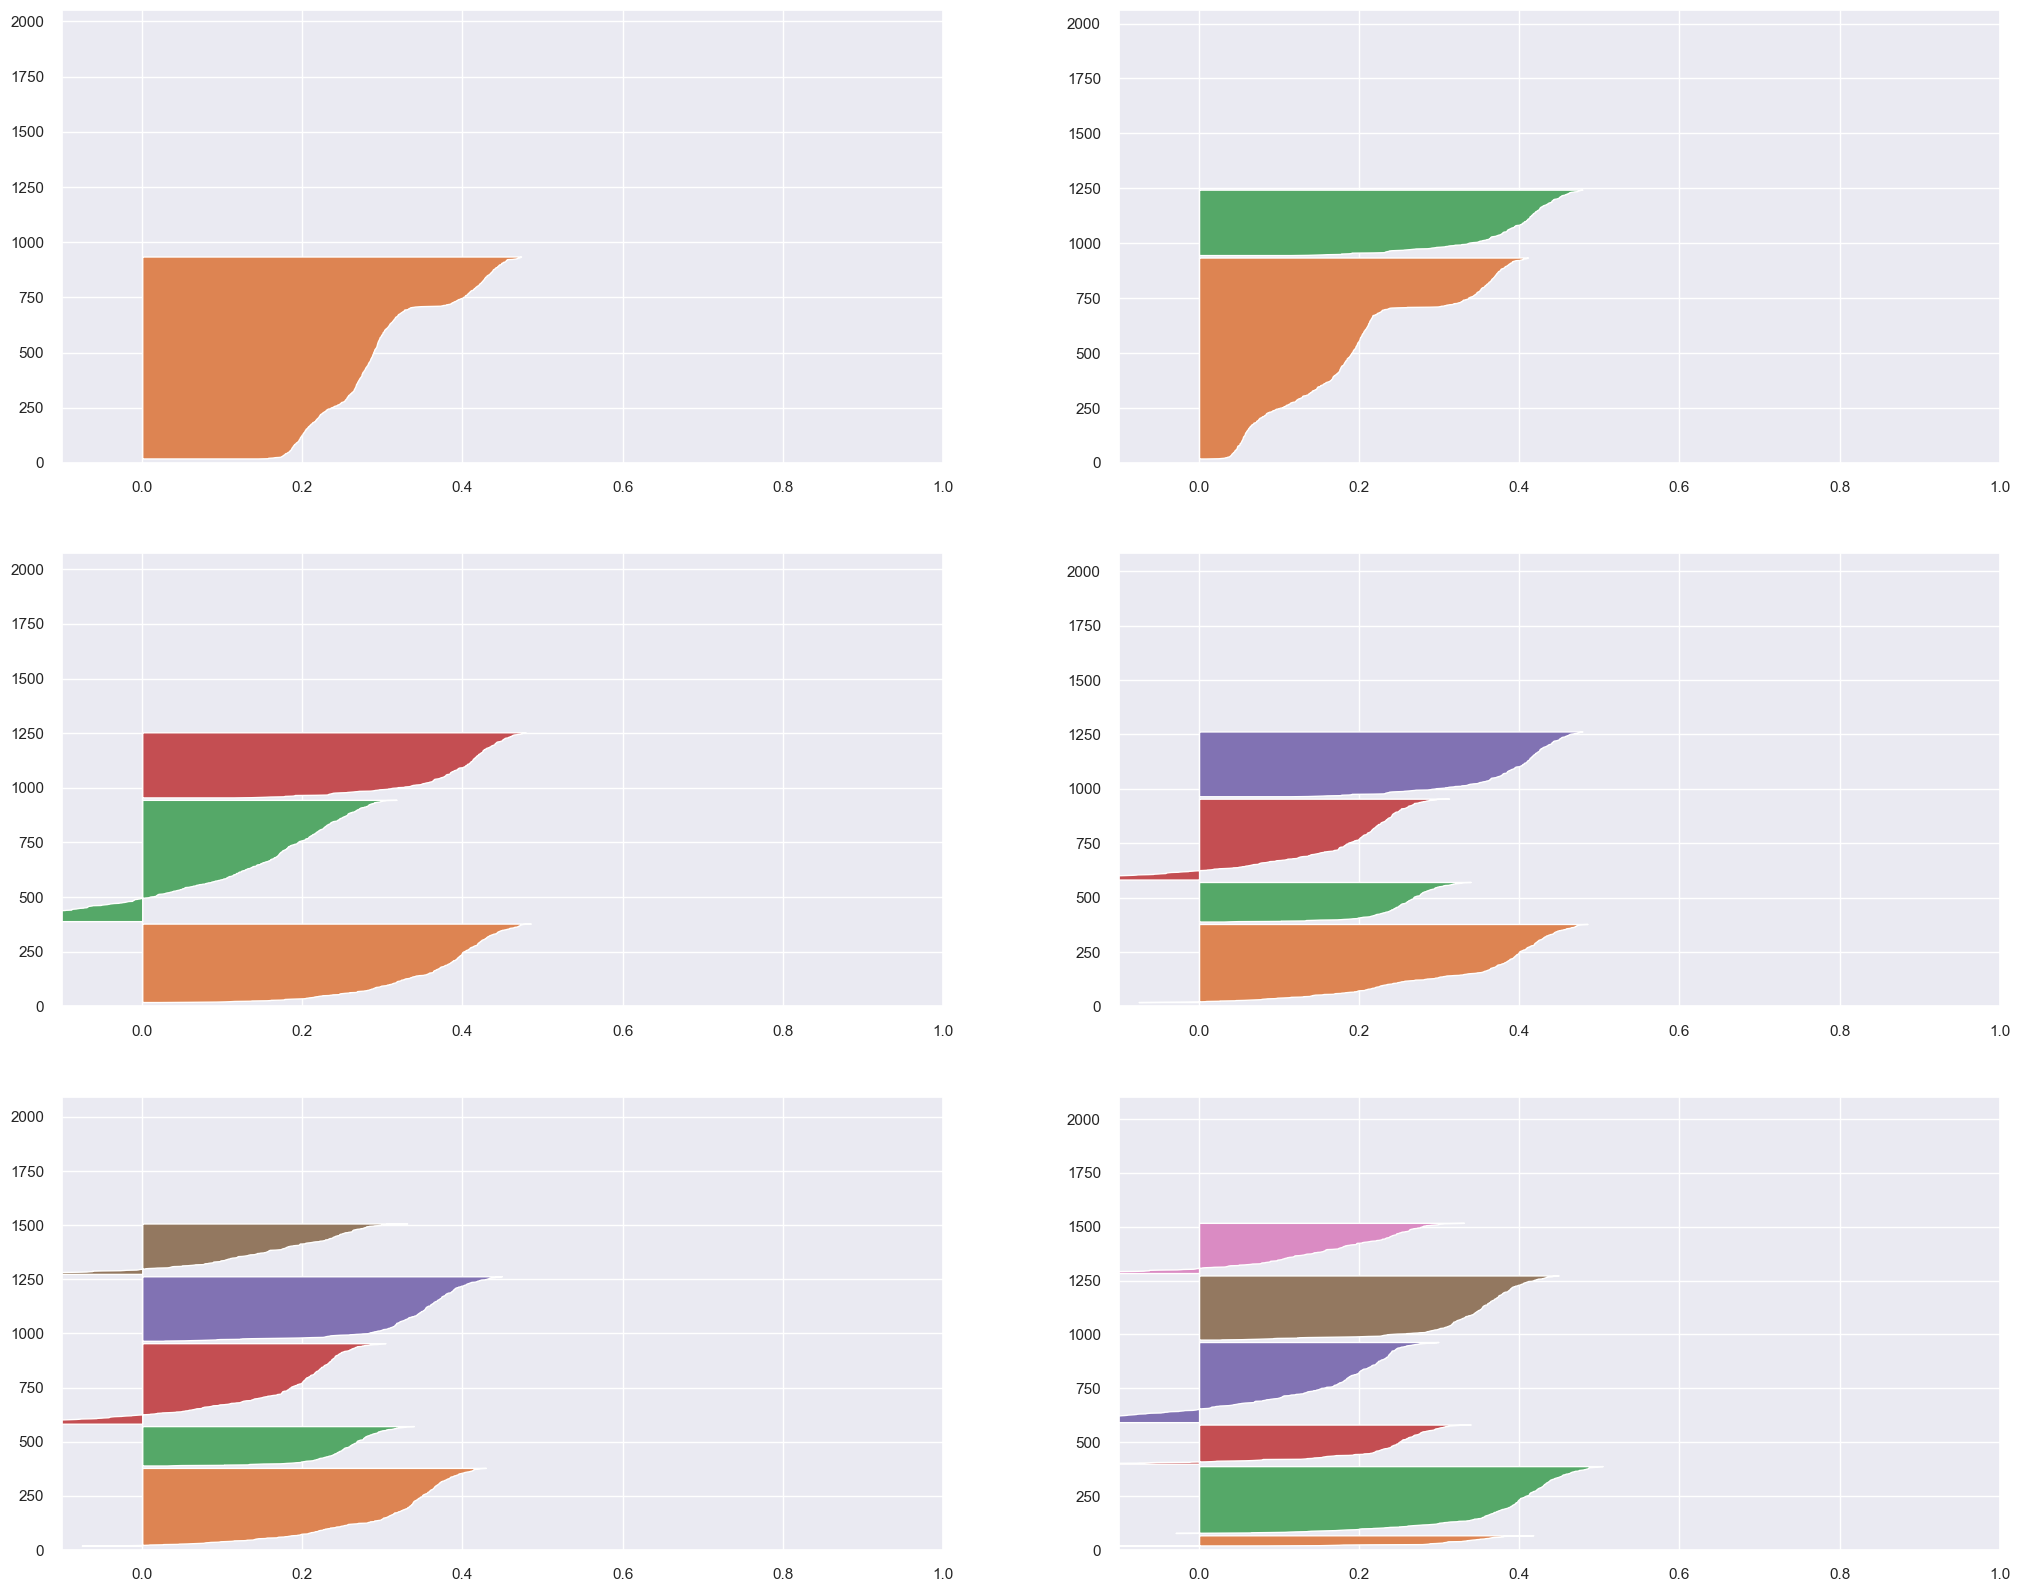

In [144]:
fig,ax = plt.subplots(3,2)
fig.set_size_inches(25,20)

for k in clusters:
    q,mod = divmod(k,2)
    
    ax[q-1,mod].set_xlim([-0.1,1])
    ax[q-1,mod].set_ylim([0,len(X) + (k+1)*10])
    # model definition    
    hc_model = hr.linkage(X,'ward')

    #model predict    
    labels = hr.fcluster(hc_model,k,criterion='maxclust')

    #model performace    
    hc_k = (sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))
    print(f'For K = {k} Silhouette: {hc_k}')
    
    ss_values = sklearn.metrics.silhouette_samples(X,labels)
    y_lower=10
    for i in range(k):

        ith_ss_values = ss_values[labels==i]
        size_cluster = ith_ss_values.shape[0]
        ith_ss_values = np.sort(ith_ss_values)
        y_upper = y_lower + size_cluster
        ax[q-1,mod].fill_betweenx(np.arange(y_lower,y_upper),0,ith_ss_values)
        y_lower = y_upper+10

## Results

In [158]:
# Model name | k=2 | k=3 | k=4 | k=5
# Kmeans        ss    ss    ss    ss
# GMM           ss    ss    ss    ss
# HC            ss    ss    ss    ss
# DBSCAN        ss    ss    ss    ss

df_results = pd.DataFrame({
    'Kmeans': sil_k,
    'GMM': gmm_list,
    'HC': hc_list,
}).T
df_results.columns = clusters
df_results.style.highlight_max(color='lightgreen',axis=1)

,2,3,4,5,6,7
Kmeans,0.360749,0.280462,0.293252,0.299389,0.282735,0.260839
GMM,0.195382,0.076365,0.208862,0.232916,0.281587,0.211728
HC,0.360749,0.280264,0.287620,0.294271,0.281569,0.280883


# Model training

In [159]:
#model training
k = 4
kmeans = c.KMeans(init='random',n_clusters=k,n_init=10,max_iter=300,random_state=42)
#model training
kmeans.fit(X)
#clustering
labels = kmeans.labels_

### Cluster validation

In [160]:
# WSS
print('WSS value',kmeans.inertia_)

## SS (Silhouette Score)
print('SS value',sklearn.metrics.silhouette_score(X,labels,metric='euclidean'))

WSS value 1332.3848530511577
SS value 0.2683132906582162


### Cluster analysis

In [161]:
df9 = df8.copy()
df9['clusters'] = labels

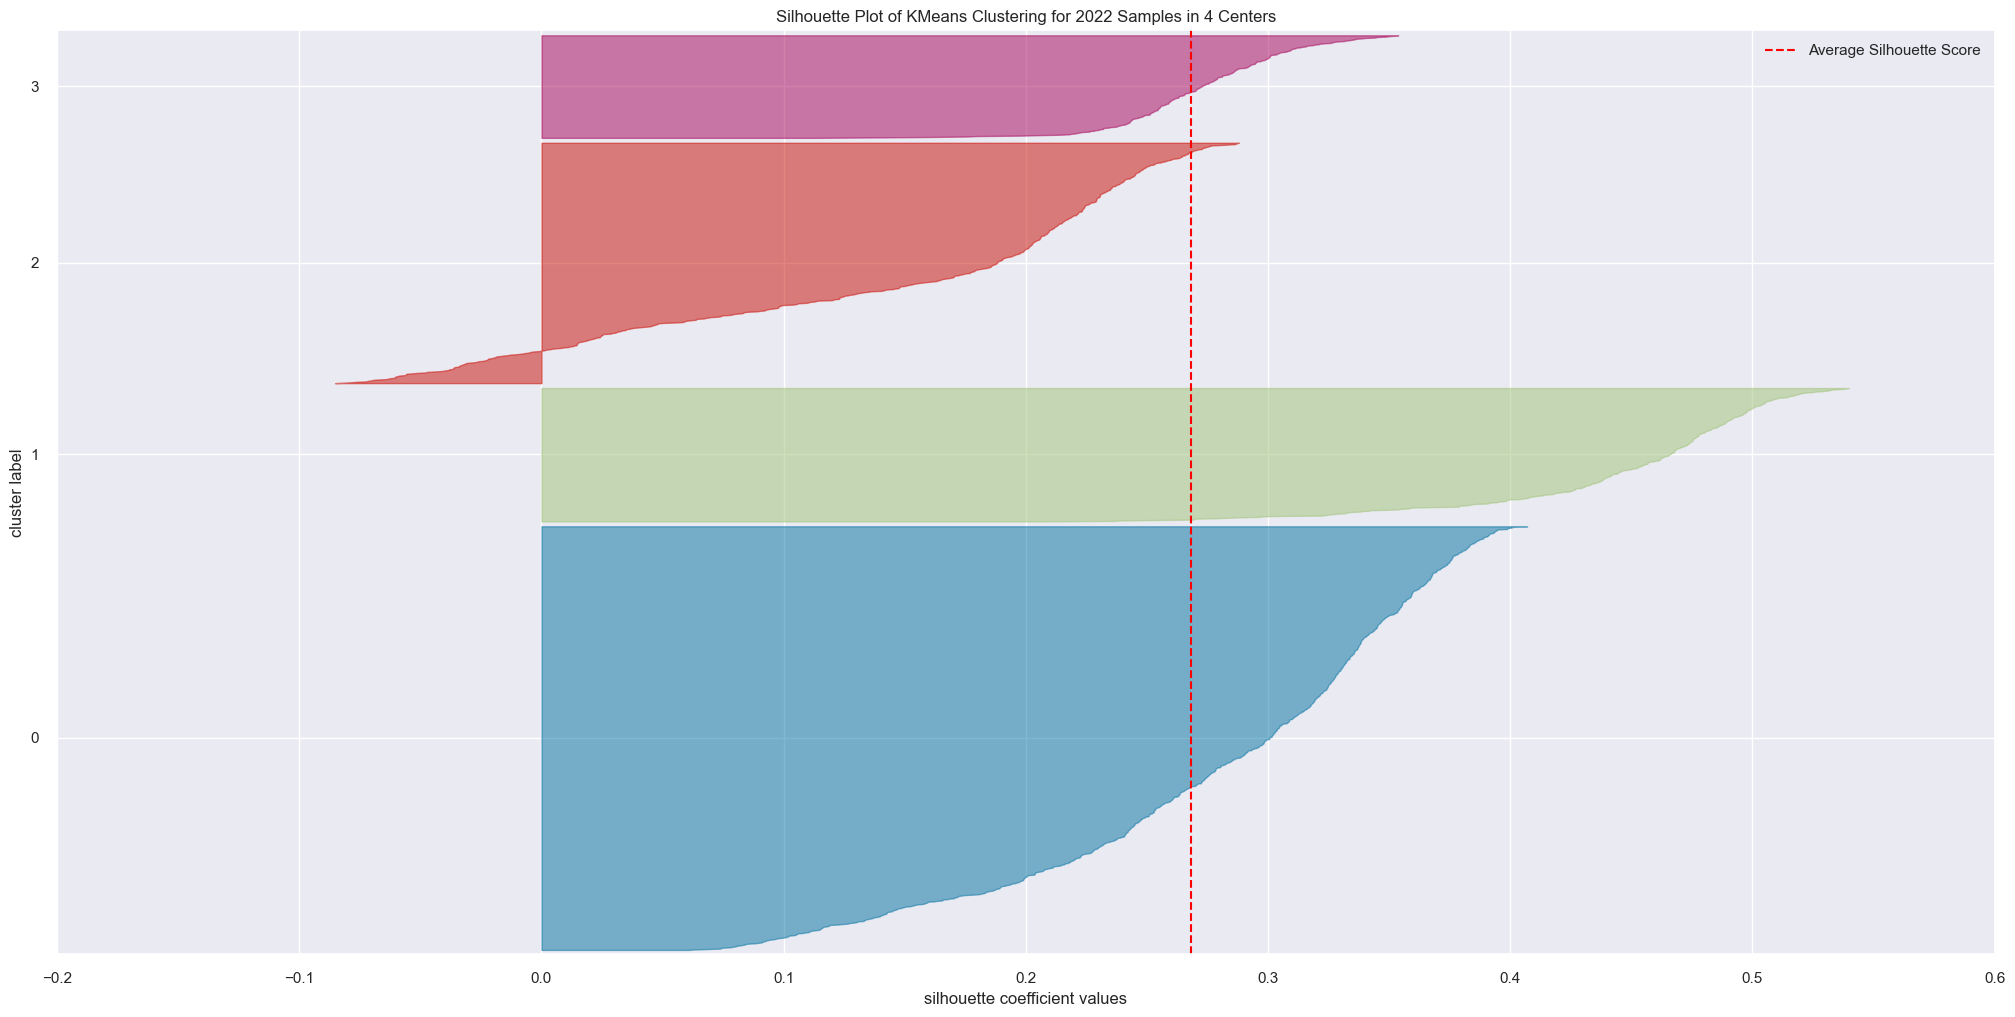

In [162]:
visualizer = SilhouetteVisualizer(kmeans,colors='yellowbrick')
visualizer.fit(X)
visualizer.finalize()

# Cluster profile

In [164]:
df10 = pd.read_csv(path_local+'src/data/df_prep.csv')
df10 = df10[cols_selected]
df10['clusters'] = labels

In [165]:
df10.columns

Index(['id', 'income', 'recency', 'mnt_wines', 'mnt_fruits',
       'mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products',
       'mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',
       'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month',
       'age', 'n_family_members', 'days_since_signup', 'income_per_member',
       'total_spent', 'clusters'],
      dtype='object')

In [166]:
# number of customers
df_cluster = df10[['id','clusters']].groupby('clusters').count().reset_index()
df_cluster['perc_customer_%'] = np.round_((df_cluster['id']/df_cluster['id'].sum())*100,2)

# Loop para iterar sobre as variáveis
for var in ['income','recency', 'mnt_wines', 'mnt_fruits','mnt_meat_products', 'mnt_fish_products', 'mnt_sweet_products','mnt_gold_prods', 'num_deals_purchases', 'num_web_purchases',            'num_catalog_purchases', 'num_store_purchases', 'num_web_visits_month','age', 'n_family_members', 'days_since_signup', 'income_per_member','total_spent']:
    
    df_avg_var = df10[[var,'clusters']].groupby('clusters').mean().reset_index()
    df_cluster = pd.merge(df_cluster, df_avg_var, how='inner', on='clusters')


In [169]:
pd.set_option('display.max_columns', None)
df_cluster.sort_values(by='total_spent',ascending=False)

,clusters,id,perc_customer_%,income,recency,mnt_wines,mnt_fruits,mnt_meat_products,mnt_fish_products,mnt_sweet_products,mnt_gold_prods,num_deals_purchases,num_web_purchases,num_catalog_purchases,num_store_purchases,num_web_visits_month,age,n_family_members,days_since_signup,income_per_member,total_spent
2,2,540,26.71,69625.590741,47.737037,594.927778,55.929630,339.079630,80.364815,56.188889,73.205556,2.001852,5.809259,5.238889,8.431481,3.914815,53.572222,2.198148,391.303704,32504.849383,1199.696296
3,3,231,11.42,65577.948052,50.562771,495.454545,51.670996,372.125541,71.961039,54.043290,64.588745,1.203463,4.493506,4.575758,7.350649,3.731602,51.008658,1.000000,347.043290,65577.948052,1109.844156
0,0,951,47.03,40552.301788,48.321767,144.761304,9.103049,51.063091,13.050473,10.241851,28.512093,2.363828,3.348055,1.145110,4.372240,6.214511,48.683491,2.735016,336.826498,14974.739748,256.731861
1,1,300,14.84,45393.100000,51.570000,150.466667,7.753333,52.113333,10.583333,8.320000,22.603333,3.606667,3.160000,1.086667,4.383333,6.343333,54.536667,4.090000,334.093333,11136.511500,251.840000
